In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import numpy as np

data = pd.read_csv("https://raw.githubusercontent.com/phamdinhkhanh/datasets/cf391fa1a7babe490fdd10c088f0ca1b6d377f59/shopping-data.csv", header=0, index_col=0)
print('data shape: ', data.shape)
data.head()

data shape:  (200, 4)


,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [2]:
# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values
print(X.shape)
std = MinMaxScaler()
X_std = std.fit_transform(X)

(200, 2)


Chúng ta nhận thấy rằng các trường dữ liệu có sự khác biệt về độ lớn đơn vị giữa các biến nên tiếp theo cần chuẩn khoá dữ liệu để đồng nhất đơn vị giữa chúng. Chúng ta chuẩn hoá MinMaxScaler(). Đối với thuật toán DBSCAN thì các điểm dữ liệu outliers sẽ tự động được tách khỏi cụm nên thuật toán không chịu ảnh hưởng nhiều bởi outliers như k-Means Clustering. Chúng ta có thể bỏ qua bước loại bỏ outliers cho bộ dữ liệu.

In [3]:
# Lựa chọn tham số

Tiếp theo chúng ta sẽ sử dụng biểu đồ k-distance như đã trình bày ở mục xác định tham số để lựa chọn khoảng cách ϵ phù hợp cho mô hình DBSCAN. Không mất đi tính chất của khoảng cách của dữ liệu thì chúng ta giả định hàm khoảng cách được lựa chọn là euclidean distance. Cuối cùng chúng ta lựa chọn số lượng điểm dữ liệu tối thiểu nằm trong vùng lân cận là minPts=11 (theo nguyên tắc chung thì minPts cần tối thiểu bằng 2×dim của bộ dữ liệu). Điều này tương ứng với trong thuật toán k-Means mà chúng ta áp dụng để vẽ biểu đồ k-distance thì cần lựa chọn số láng giềng k=10.

Khi xây dựng mô hình với những tham số này sẽ tạo ra được những cụm phân chia có tính chất tổng quát nhất. Tránh được các trường hợp có quá nhiều cụm nhỏ lẻ được phân chia và nhiễu được tạo thành khi ϵ nhỏ và trường hợp khác là toàn bộ các điểm bị phân về một cụm nếu lựa chọn ϵ lớn.

Text(0.5, 1.0, 'Sorting Maximum Distance in k Nearest Neighbor of kNN')

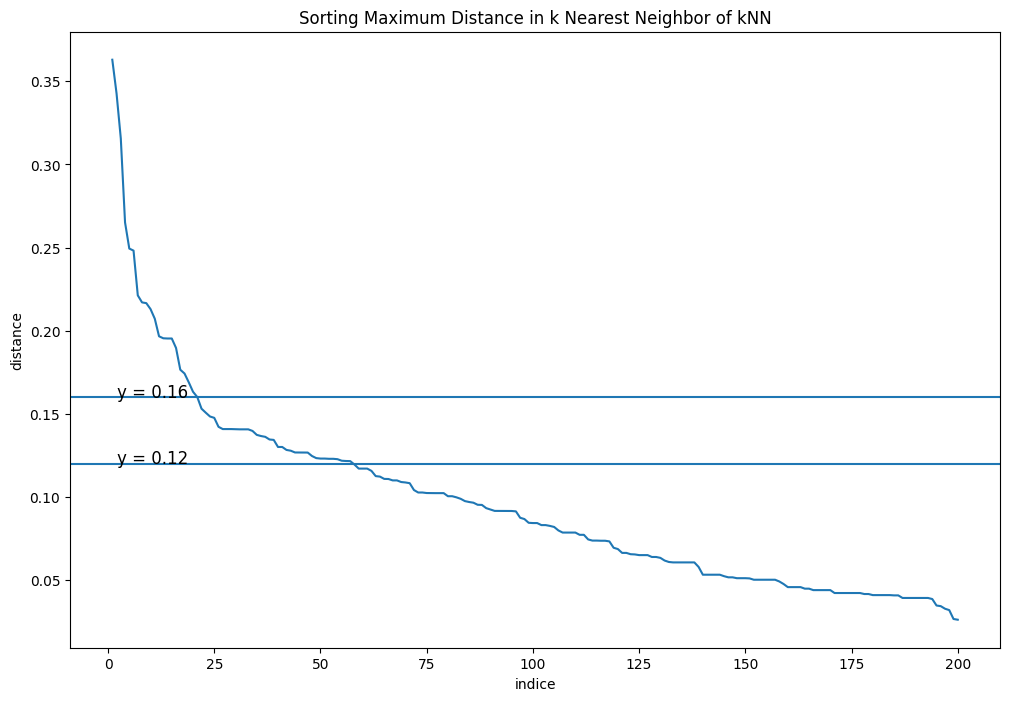

In [4]:
from sklearn.neighbors import NearestNeighbors


# Xây dựng mô hình k-Means với k=10
neighbors = 10
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(X_std)

# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(X_std)

# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, neighbors-1], reverse=True)

# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
plt.axhline(y=0.12)
plt.text(2, 0.12, 'y = 0.12', fontsize=12)
plt.axhline(y=0.16)
plt.text(2, 0.16, 'y = 0.16', fontsize=12)
plt.ylabel('distance')
plt.xlabel('indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')

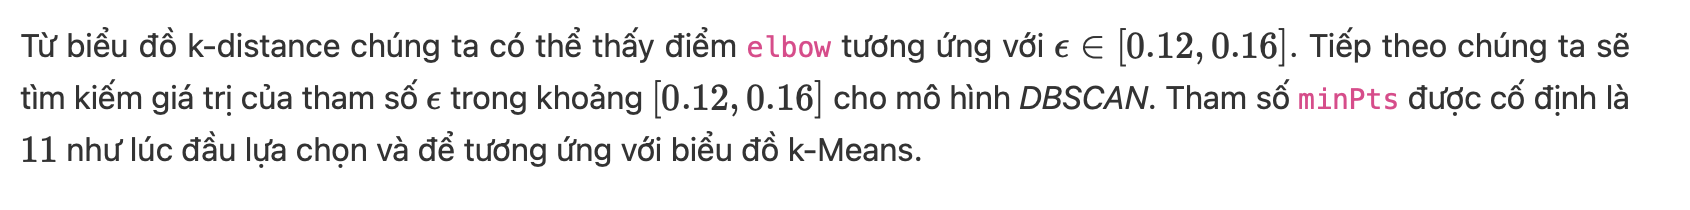

In [ ]:
DBSCAN(eps=0.5, min_samples=5,  metric='euclidean',  algorithm='auto')

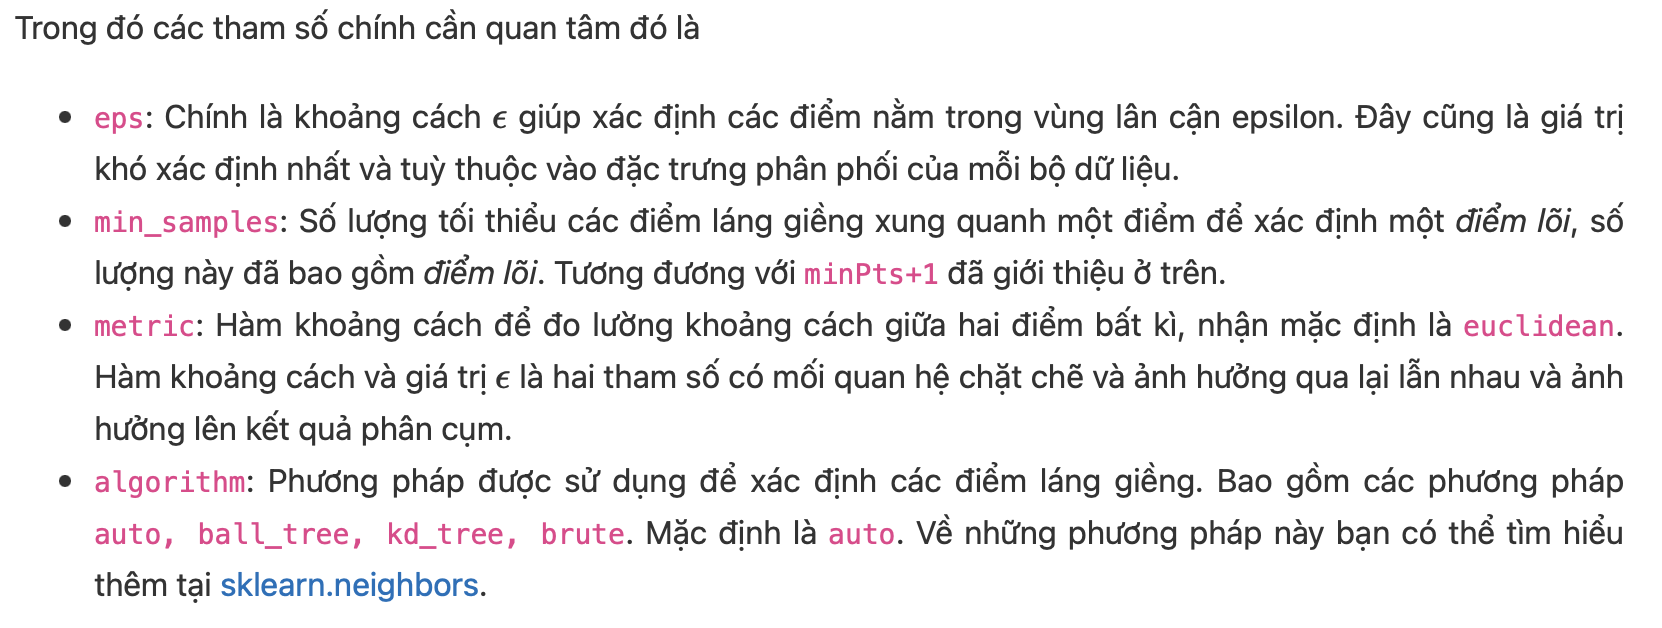

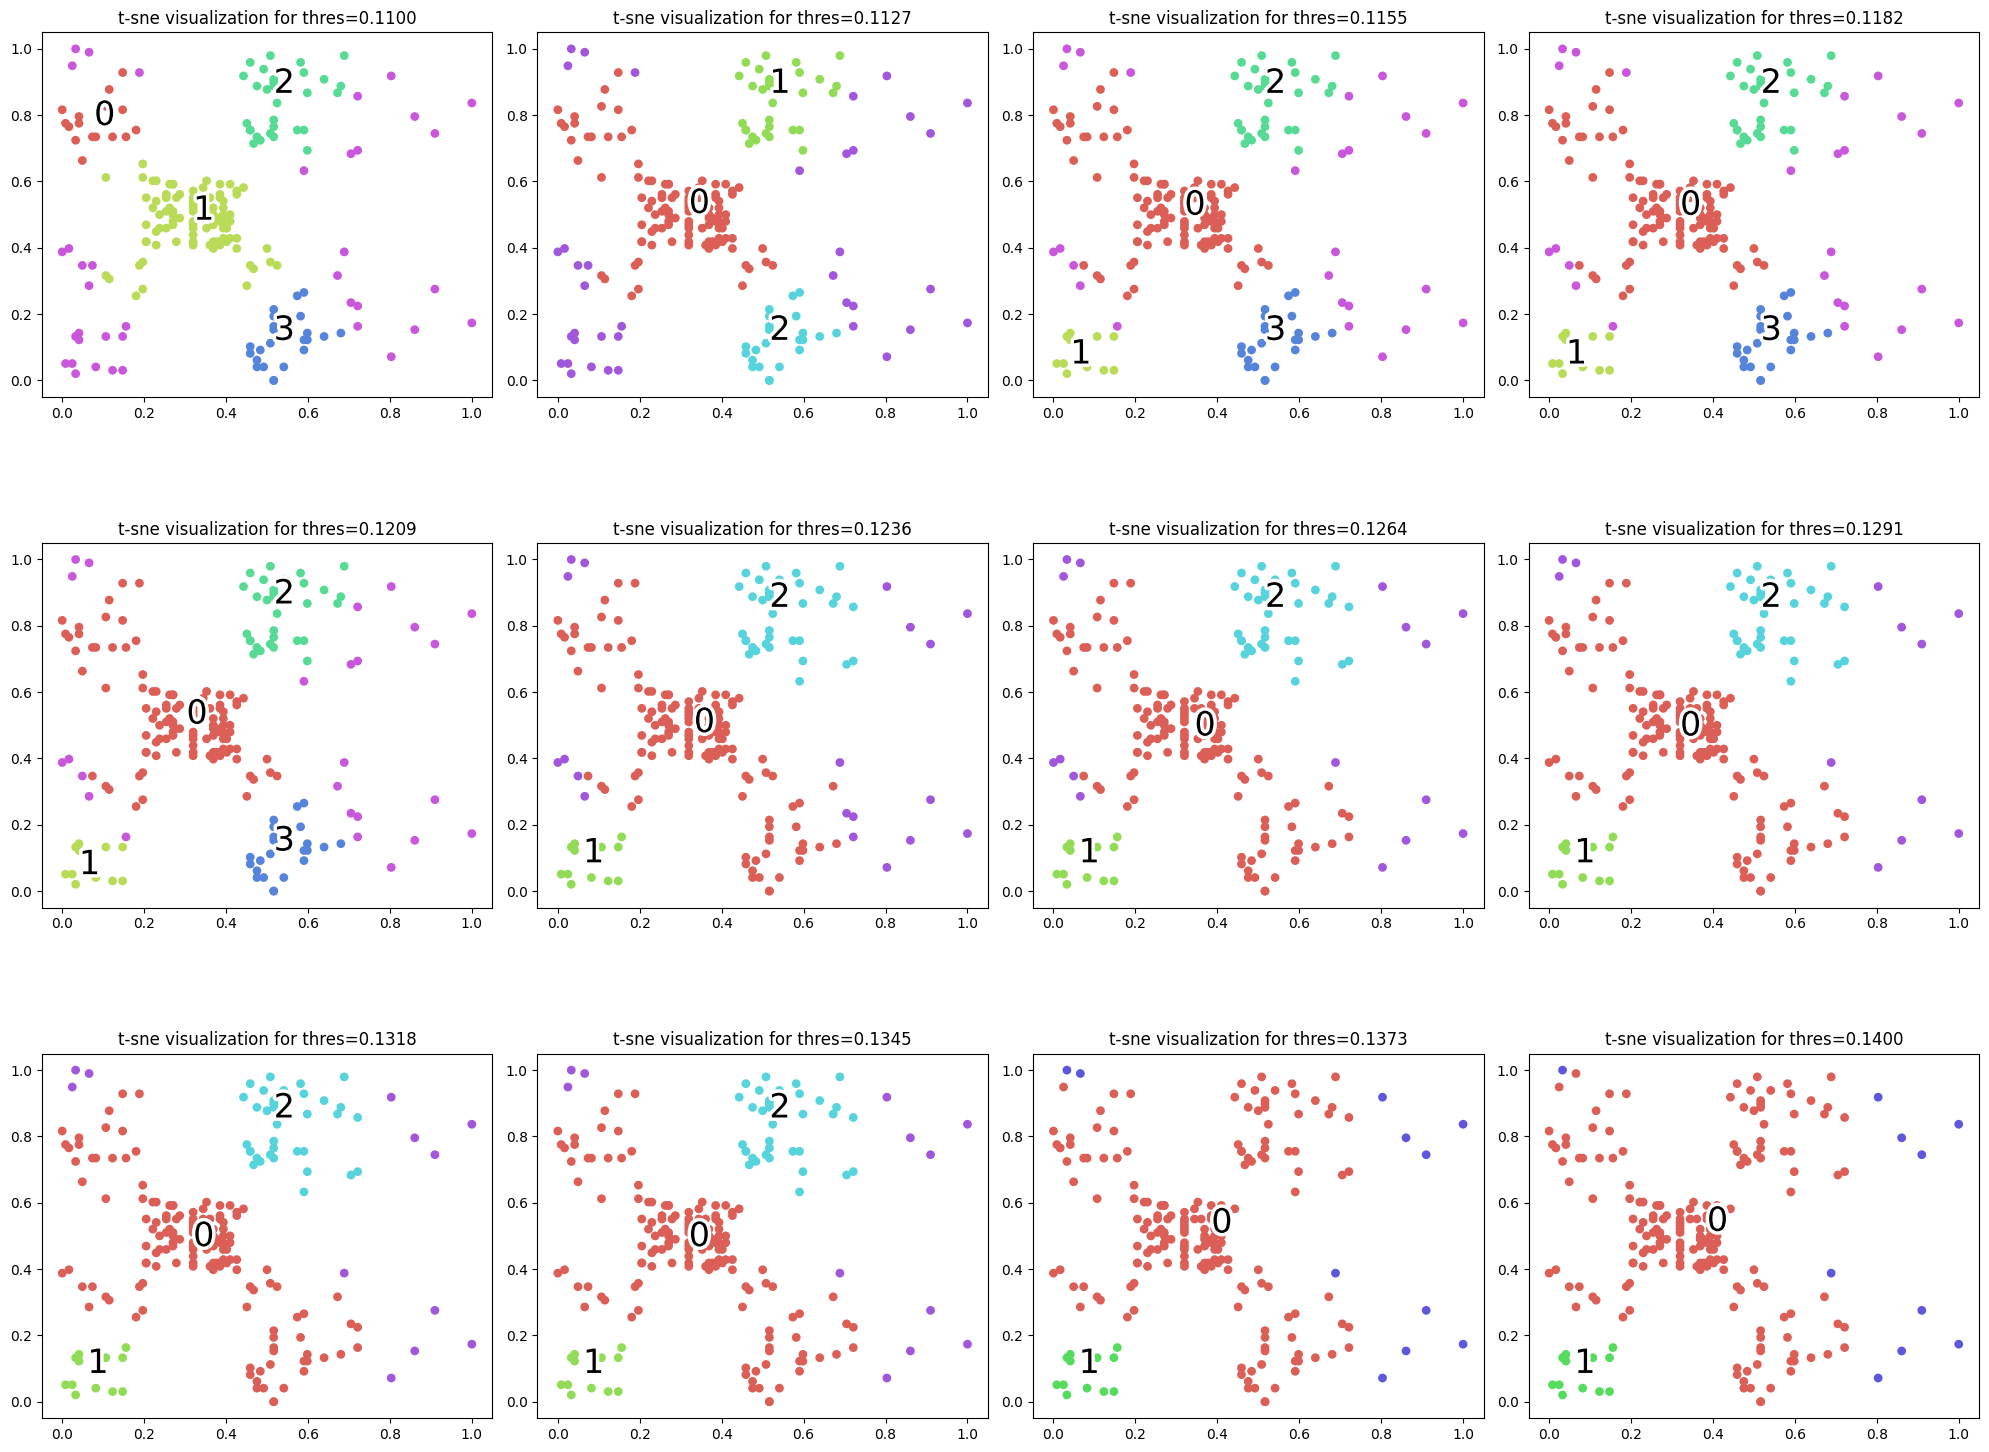

In [6]:
from matplotlib.gridspec import GridSpec
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

def _plot_kmean_scatter(X, labels, gs, thres):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    # vẽ biểu đồ scatter
    ax = plt.subplot(gs)
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(int)])

    # thêm nhãn cho mỗi cluster
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        indices = (labels == i)
        xtext, ytext = np.median(X[indices, :], axis=0)
        if not (np.isnan(xtext) or np.isnan(ytext)):        
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)
    plt.title('t-sne visualization for thres={:.4f}'.format(thres))

gs = GridSpec(3, 4)
plt.figure(figsize = (25, 18))
plt.subplots_adjust(wspace=0.1,hspace=0.4)

for i, thres in enumerate(np.linspace(0.11, 0.14, 12)):
    dbscan = DBSCAN(eps=thres, min_samples=11, metric='euclidean')
    labels = dbscan.fit_predict(X_std)
    _plot_kmean_scatter(X_std, labels, gs[i], thres)

Giá trị của epsilon ảnh hưởng khá nhạy lên kết quả phân cụm. Căn cứ vào biểu đồ chúng ta có thể lựa chọn ϵ=0.1209 là giá trị mà các cụm có vẻ mang lại kết quả phân chia tổng quát nhất trên tập dữ liệu huấn luyện. Giá trị này có thể khác biệt theo phương pháp chuẩn hoá dữ liệu và cách lựa chọn trường dữ liệu đầu vào.